In [21]:
#hide
! [ -e /content ] && pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

In [22]:
#hide
from fastbook import *
from fastai.vision.widgets import *

In [23]:
key = os.environ.get('AZURE_SEARCH_KEY', '6916f4d6bb5047fe9245894e1ad331ac')
results = search_images_bing(key, 'football player')
ims = results.attrgot('contentUrl')

In [24]:
dest = 'images/fp.jpg'
download_url(ims[0], dest)

Path('images/fp.jpg')

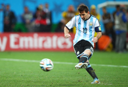

In [25]:
im = Image.open(dest)
im.to_thumb(128,128)

In [26]:
fps_types = 'barcelona','real madrid','benfica', 'porto', 'sporting CP', 'Liverpool', 'Al Nasr'
path = Path('football_players')

In [8]:
if not path.exists():
    path.mkdir()
    for o in fps_types:
        dest = (path/o)
        dest.mkdir(exist_ok=True)
        results = search_images_bing(key, f'{o} football player')
        download_images(dest, urls=results.attrgot('contentUrl'))

In [27]:
def convert_to_rgba(fn):
    img = PILImage.create(fn)
    if img.mode == 'P':
        img = img.convert('RGBA')
        img.save(fn, format='PNG')

fns = get_image_files(path)
for fn in fns:
    convert_to_rgba(fn)

In [28]:
fns = get_image_files(path)
failed = verify_images(fns)
failed.map(Path.unlink);
len(failed)

0

In [29]:
football_players = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.3, seed=12),
    get_y=parent_label,
    item_tfms=Resize(128))

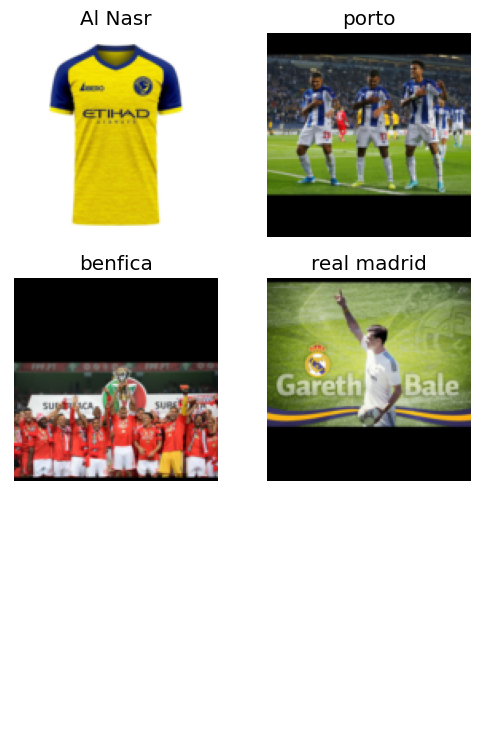

In [30]:
dls = football_players.dataloaders(path)
football_players = football_players.new(item_tfms=Resize(128, ResizeMethod.Pad, pad_mode='zeros'))
dls = football_players.dataloaders(path)
dls.train.show_batch(max_n=4, nrows=3, unique=False)

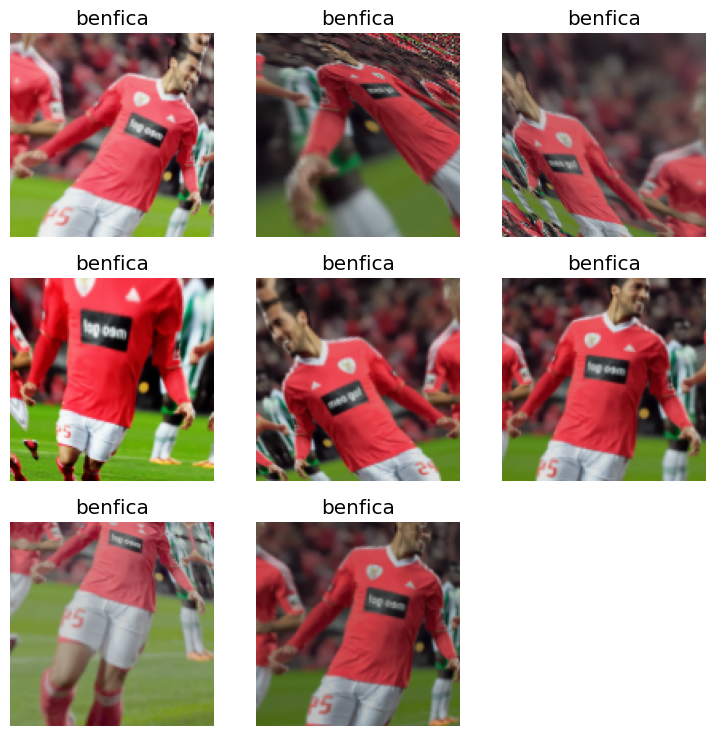

In [13]:
football_players = football_players.new(item_tfms=Resize(128), batch_tfms=aug_transforms(mult=2))
dls = football_players.dataloaders(path)
dls.train.show_batch(max_n=8, nrows=3, unique=True)

In [31]:
football_players = football_players.new(
    item_tfms=RandomResizedCrop(224, min_scale=0.5),
    batch_tfms=aug_transforms())

In [32]:
dls = football_players.dataloaders(path)

In [33]:
learn = vision_learner(dls, resnet34, metrics=error_rate)
learn.fine_tune(4)

epoch,train_loss,valid_loss,error_rate,time


KeyboardInterrupt: 

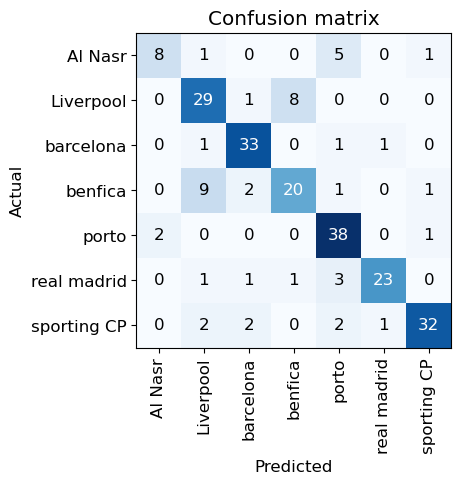

In [17]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

In [34]:
interp.plot_top_losses(5, nrows=3)

NameError: name 'interp' is not defined

In [35]:
cleaner = ImageClassifierCleaner(learn)
cleaner

In [25]:
for idx in cleaner.delete(): cleaner.fns[idx].unlink()
for idx,cat in cleaner.change(): shutil.move(str(cleaner.fns[idx]), path/cat)

In [ ]:
learn.export()

In [10]:
path = Path()
path.ls(file_exts='.pkl')

(#1) [Path('export.pkl')]

In [11]:
learn_inf = load_learner(path/'export.pkl')
learn_inf.dls.vocab
learn_inf.predict('images/fp.jpg')


/root/mambaforge/lib/python3.10/site-packages/fastai/torch_core.py:263: UserWarning: 'has_mps' is deprecated, please use 'torch.backends.mps.is_built()'
  return getattr(torch, 'has_mps', False)


('barcelona',
 tensor(2),
 tensor([0.0870, 0.0075, 0.8450, 0.0084, 0.0367, 0.0012, 0.0142]))

In [12]:
btn_upload = widgets.FileUpload()
btn_upload

FileUpload(value=(), description='Upload')

In [13]:
btn_run = widgets.Button(description='Classify')
btn_run

Button(description='Classify', style=ButtonStyle())

In [14]:
btn_upload = SimpleNamespace(data = ['images/fp.jpg'])

In [15]:
img = PILImage.create(btn_upload.data[-1])

In [16]:
out_pl = widgets.Output()
out_pl.clear_output()
with out_pl: display(img.to_thumb(128,128))
out_pl

Output()

In [17]:
pred,pred_idx,probs = learn_inf.predict(img)

In [18]:
lbl_pred = widgets.Label()
lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'
lbl_pred

Label(value='Prediction: barcelona; Probability: 0.8450')

In [19]:
def on_click_classify(change):
    img = PILImage.create(btn_upload.data[-1])
    out_pl.clear_output()
    with out_pl: display(img.to_thumb(128,128))
    pred,pred_idx,probs = learn_inf.predict(img)
    lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'

btn_run.on_click(on_click_classify)

In [20]:
btn_upload = widgets.FileUpload()
VBox([widgets.Label('Select your football photo!'), 
      btn_upload, btn_run, out_pl, lbl_pred])